In [1]:
#hide_input
%run code/six_source_summary

In [2]:
name='PKS 0208-512'
pgm = setup_pgms([name])[0]

yr=365.255
df = pd.DataFrame(pgm.find_peaks(power='p1')).query('1.9e-3<f<5e-3& p1>400')
df.loc[:,'fy'] = df.f*yr; df

,f,p1,fy
8,0.002176,861.476501,0.794745
11,0.003163,595.674255,1.155470
14,0.004186,429.693146,1.529020


In [3]:
def phase_df(self, diff=True):
    """ Return a phase dataframe
    """
    if not hasattr(self, 'amplitude_df'):
        self.amplitudes()
    adf = self.amplitude_df.copy()
    adf.loc[:,'phi'] = np.arctan2(adf.acos, adf.asin)
    if not diff:
        return adf
    delphi = np.mod(np.diff(adf.phi), np.pi)
    # delphi[delphi<-np.pi] += 2*np.pi
    f = 0.5*(adf.f.values[1:]+adf.f.values[:-1])
    return pd.DataFrame(dict(f=f, delphi=delphi))
dfx = pgm.phase_df()
dfx

TimeSeries: creating amplitude spectra


,f,delphi
0,0.000046,1.067382
1,0.000076,0.149052
2,0.000107,0.948732
3,0.000137,0.135207
4,0.000168,0.451587
...,...,...
8186,0.249863,-0.549028
8187,0.249893,-0.116371
8188,0.249924,0.128040
8189,0.249954,0.219898


In [4]:
pgm.tspan/pgm.tsamp, len(pgm.power_df),pgm

(5079.0, 8192, TimeSeries: 5079 cells for MJD 54683.0-59762.0)

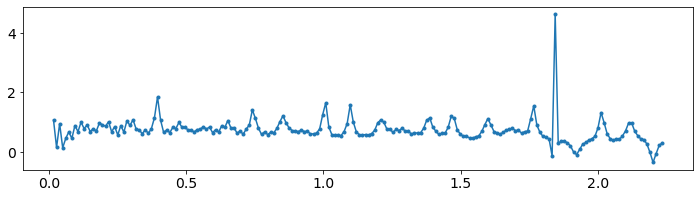

In [11]:
plt.figure(figsize=(12,3))
n=200
plt.plot(dfx.f[:n]*yr, dfx.delphi[:n], '.-');

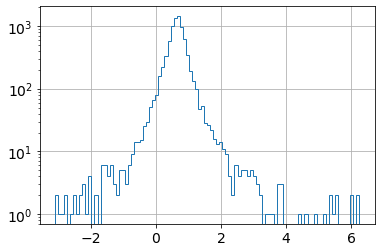

In [15]:
plt.hist(dfx.delphi, 100, log=True, histtype='step');
plt.grid();

In [21]:
np.degrees(dfx.delphi).describe()

count    8191.000000
mean       37.029388
std        26.763098
min      -177.813950
25%        28.234874
50%        36.711529
75%        45.082487
max       358.201263
Name: delphi, dtype: float64

In [22]:
360/37

9.72972972972973

In [14]:
adf.loc[:,'fyr'] = adf.f*yr; 
delphi = np.mod(np.diff(adf.phi), 2*np.pi)
# delphi[delphi<-np.pi] += 2*np.pi


array([       nan, 1.0673816 , 0.14905202, ..., 0.12804013, 0.21989837,
       0.2734205 ], dtype=float32)

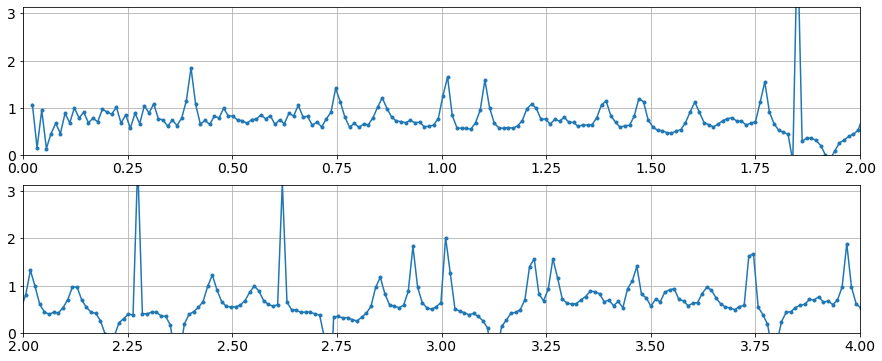

In [17]:
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(15,6))
ax1.plot(adf.fyr[1:], delphi, '.-');
ax1.set(xlim=(0,2.0), ylim=(0,np.pi)); ax1.grid();
ax2.plot(adf.fyr[1:], delphi, '.-');
ax2.set(xlim=(2,4), ylim=(0,np.pi)); ax2.grid();


<h2 align="center"> A look at PKS 0208-512</h2>
    
<h6 align="right">2022-07-28 13:15</h6>

Since the Kerr periodogram does not support the existence of oscillations with a period $2.2\pm 0.2$, 
and the behavior of the low frequency spectrum suggested 1/f noise, and further there is a suggestion
from the phase plot that the period is actually half that, I looked in more detail to try to 
check both hypotheses.


### The analysis
I redid the last plot in the previous analysis, but expanded the frequency scale, made it semilogy,
and overplotted an empirical look at the low energy behavior
<figure style="margin-left: 5%" title="Figure 1">   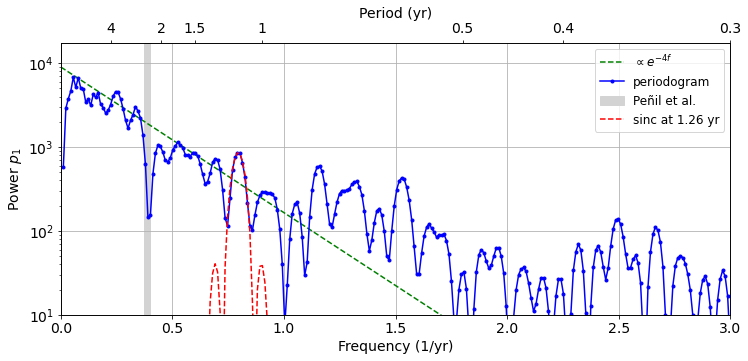 </figure>
A peak is indeed close to the hypothesized half frequency, but the low frquency behavior appears to be exponential, with 
a 0.25 yr constant, rather than 1/f.

In fact, there are two other peaks equidistant in frequency. To be investigated, 
especially to see if there is a similar behavior with other blazars.


In [10]:
#hide_input
@ipynb_doc
def study_0208():
    """ <h2 align="center"> A look at PKS 0208-512</h2>
        
    <h6 align="right">{date}</h6>
    
    Since the Kerr periodogram does not support the existence of oscillations with a period $2.2\pm 0.2$, 
    and the behavior of the low frequency spectrum suggested 1/f noise, and further there is a suggestion
    from the phase plot that the period is actually half that, I looked in more detail to try to 
    check both hypotheses.

    
    ### The analysis
    I redid the last plot in the previous analysis, but expanded the frequency scale, made it semilogy,
    and overplotted an empirical look at the low energy behavior
    {fig}
    A peak is indeed close to the hypothesized half frequency, but the low frquency behavior appears to be exponential, with 
    a 0.25 yr constant, rather than 1/f.
    
    In fact, there are two other peaks equidistant in frequency. To be investigated, 
    especially to see if there is a similar behavior with other blazars.
    """
    with capture_hide('setup printout') as txt:
        names=['PKS 0208-512']
        pgm = setup_pgms(names)[0]
    
    period=[2.6,0.2]
    power='p1'; T= pgm.tspan
    yr=365.25
    penil_f = 1/(yr*period[0])
    df = pgm.find_peaks(power=power).query('f<3e-3')

    close = np.abs(2*penil_f-df.f)< 1/T
    df.loc[:,'close'] = close
    # print(name, penil_f, sum(close), df)
    if sum(close)>0: # 'found'
        peak = df[close].iloc[0]
        sinc = Sinc(peak.p1, peak.f*yr, yr/T) 
    else: sinc=None

    fig, ax = plt.subplots(figsize=(12,5))
    x=np.linspace(0.0,2)
    ax.plot(x, 9e3*(np.exp(-x*4)), '--g',label=r'$\propto e^{-4f}$');
    lowfreqplot(pgm, ax=ax, yscale='log', ylim=(10,None), xlim=(0,3),
               pticks=[0.3,0.4,0.5,1,1.5,2,4], penil=period,
               over=sinc)
    return locals()
study_0208()

In [24]:
from wtlike.simulation import Simulation
locals().update(amp=0.05, freq=0.5, T=50, srate=24, rng=None)
def periodic(t):
    return 1e-6 * ( 1+ amp*np.cos(2*np.pi*freq*t) )


with capture_hide('Output during setup') as setup_txt:
    sim = Simulation('periodic', src_flux=periodic, tstart=0, tstop=T, rng=rng)
    sim.run()
    cd = TimeSeries(sim, tsamp=1/srate, )
    cd.power_spectrum(minf=1)

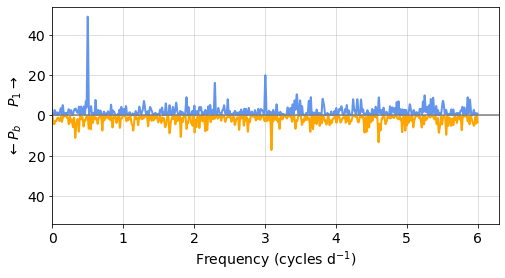

In [25]:
cd.power_plot();

## Simulation Test 
<details  class="nbdoc-description" >  <summary> Output during setup </summary>  <div style="margin-left: 5%;"><pre>generated 25838 photons<br></pre></div> </details>

Simulation details:

* Duration $T=50\ d$,  sample rate $24\ d^{-1}$
* Signal: $S(t) = 10^{-6}\ \big[1 + A \cos(2\pi f_S t)\big]$, where $f_S$ is the source 
  frequency 5.0, and the amplitude $A=0.05$. 
* Background: fixed at $10^{-6}$.

<figure style="margin-left: 5%" title="Figure 1">   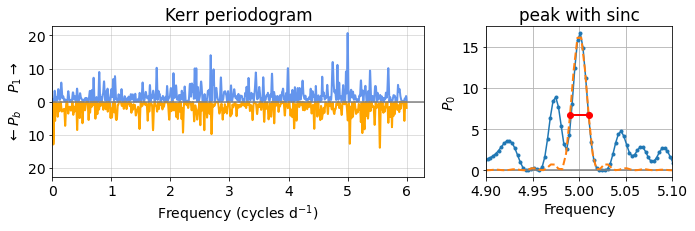  <figcaption><b>Figure 1</b>. Left plot: The full Kerr periodogram showing $P_B$ and $P_1$ up to the Nyquist frequency 6.0.
        Right plot: The $P_0$ spectral measure overlaid with the sinc function at the frequency $f_S$
        adjusted to match the peak and with its expected width, $1/T=0.02$. (Note that the FFT processing uses
        zero padding by at least a factor of 5 to improve the FFT resolution.)</figcaption></figure>
    
### Peak detection

Peak finding finds 185 peaks.
The nearest peak to the expected signal:
<br><div style="margin-left: 5%;"><pre>f      5.000471<br>p0    16.667437<br>Name: 152, dtype: float32</pre></div>

<figure style="margin-left: 5%" title="Figure 2">   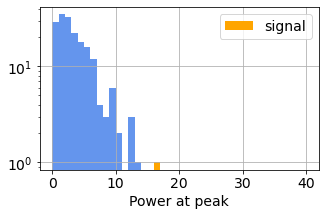  <figcaption><b>Figure 2</b>. Distribution of peak power values</figcaption></figure>


In [15]:
# collapse-hide
@ipynb_doc
def sim_test(amp=0.05, freq=5, T=50, srate=24, rng=None):
    r"""
    ## Simulation Test 
    {setup_txt}
    
    Simulation details:
    
    * Duration $T={T}\ d$,  sample rate ${srate}\ d^{-1}$
    * Signal: $S(t) = 10^{-6}\ \big[1 + A \cos(2\pi f_S t)\big]$, where $f_S$ is the source 
      frequency {freq:.1f}, and the amplitude $A={amp}$. 
    * Background: fixed at $10^{-6}$.

    {fig1}
        
    ### Peak detection
    
    Peak finding finds {nump} peaks.
    The nearest peak to the expected signal:
    <br>{signal_text}
    
    {fig2}
    """
    global cd
    from wtlike.simulation import Simulation
    def periodic(t):
        return 1e-6 * ( 1+ amp*np.cos(2*np.pi*freq*t) )
    tsamp = 1/srate
    with capture_hide('Output during setup') as setup_txt:
        sim = Simulation('periodic', src_flux=periodic, tstart=0, tstop=T, rng=rng)
        sim.run()
        cd = TimeSeries(sim, tsamp=tsamp, )
        cd.power_spectrum(minf=1)
    
    sim_info = cd.__repr__()
    delf = 1/T 
    fnyquist = 0.25/cd.tsamp
    
    def left(ax):
        cd.power_plot(ax = ax, title='Kerr periodogram');    #fig, ax = plt.subplots(figsize=(8,4))
    
    def right(ax):
        
        ax.plot(cd.power_df.f, cd.power_df.p0, '.-');
        ax.grid(True)
        ax.axhline(0, color='grey')
        xlim = (freq-5*delf,freq+5*delf)
        ax.set(xlim =xlim, 
               xlabel='Frequency', ylabel='$P_0$',title='peak with sinc');
        A, m,b = cd.power_df.p0.max(), freq,  delf
        sincsq = lambda x: A*np.sinc((x-m)/b)**2 
        x = np.linspace(*xlim)
        ax.plot(x, sincsq(x), '--', lw=2 );
        hh = np.array([freq-delf/2, freq+delf/2])
        ax.plot(hh, sincsq(hh),'o-r', lw=2);
        
    fig1 = figure(plt.figure(figsize=(12,3)), 
        caption=f"""Left plot: The full Kerr periodogram showing $P_B$ and $P_1$ up to the Nyquist frequency {fnyquist}.
        Right plot: The $P_0$ spectral measure overlaid with the sinc function at the frequency $f_S$
        adjusted to match the peak and with its expected width, $1/T={delf}$. (Note that the FFT processing uses
        zero padding by at least a factor of 5 to improve the FFT resolution.)""",
        width = 800)
    plt.subplots_adjust(wspace=0)
    gs = plt.GridSpec(1,10)

    left(  fig1.add_subplot(gs[:6]) )
    right( fig1.add_subplot(gs[7:]) )
    
    # find the peak
    peak_df = cd.find_peaks()
    nump = len(peak_df)
    
    k = peak_df.find_closest(freq)
    signal = peak_df.iloc[k] #peak_df.query(f'{freq-1/T}<x<{freq+1/T}')
    signal_text = monospace(str(signal))
    
    def peak_plot(fig):
        y = cd.power_df.p0.values
        x = cd.power_df.f.values
        xp, yp = peak_df.iloc[:,0], peak_df.iloc[:,1]
        
        ax = fig.add_subplot()
        hkw = dict(bins=np.linspace(0,40,41), histtype='stepfilled', log=True)
        ax.hist(yp, color='cornflowerblue', **hkw);
        ax.hist(signal.p0, label='signal', color='orange', **hkw);
        ax.set(xlabel='Power at peak')
        ax.legend()
        ax.grid(True)
        
            
    fig2 =  figure(plt.figure(figsize=(5,3)), 
                     caption='Distribution of peak power values')
    peak_plot(fig2)
    return locals()
# need to bix
sim_test(amp=0.05, fignum=1, rng=24)

In [32]:
def lorenzian(t, tz=2, w=0.2):
    return 1e-7/np.sqrt(1+ ((t-tz)/w)**2)
t = np.linspace(0,T,1000)

def twolor(t):
    return lorenzian(t,20)
plt.plot(t, twolor(t));

In [63]:
@ipynb_doc
def flaresim(lc, txt, T=50, rng=24):
    """
    ## {txt}
    {fig1}
    {fig2}
    {fig3}
    """
    with capture_hide('Output during setup') as setup_txt:
        siml = Simulation('lor', src_flux=lc, tstart=0, tstop=T, rng=rng)
        siml.run()
        cdl = TimeSeries(siml, tsamp=1/srate, )
        cdl.power_spectrum(minf=1)
    t = np.linspace(0,T,1000)    
    fig1, ax1 = plt.subplots(figsize=(8,2))
    ax1.plot(t, lc(t));
    ax1.set(xlabel='time', ylim=(0,None), title='Input light curve')
    
    fig2, ax2= plt.subplots(figsize=(12,4))
    cdl.power_plot(ax=ax2, pmax=20)   
    
    pdf = cdl.power_df
    fig3, ax3 = plt.subplots(figsize=(12,5))
    ax3.semilogy(pdf.f, pdf.p1.clip(1,None), '.-')
    ax3.set(xlim=(0,1.5)); ax3.grid();
    return locals()

## constant
<figure style="margin-left: 5%" title="Figure 1">   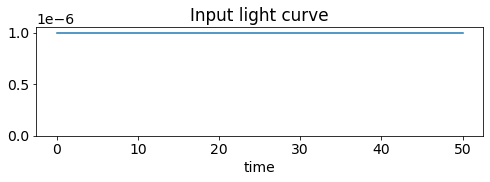 </figure>
<figure style="margin-left: 5%" title="Figure 2">   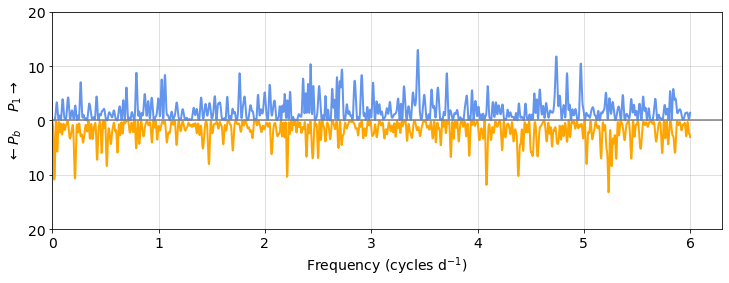 </figure>
<figure style="margin-left: 5%" title="Figure 3">   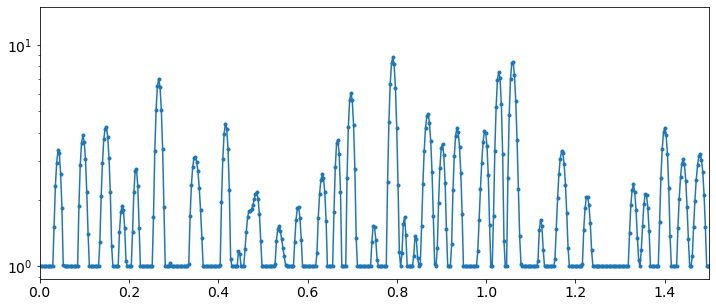 </figure>


In [54]:
flaresim(lambda t: 1e-6*np.ones(len(np.atleast_1d(t))), 'constant')

## Lorenzian, width 1
<figure style="margin-left: 5%" title="Figure 1">   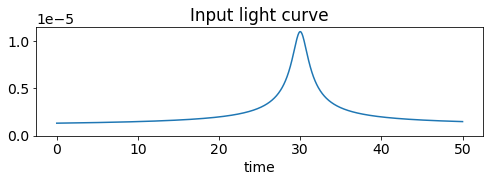 </figure>
<figure style="margin-left: 5%" title="Figure 2">   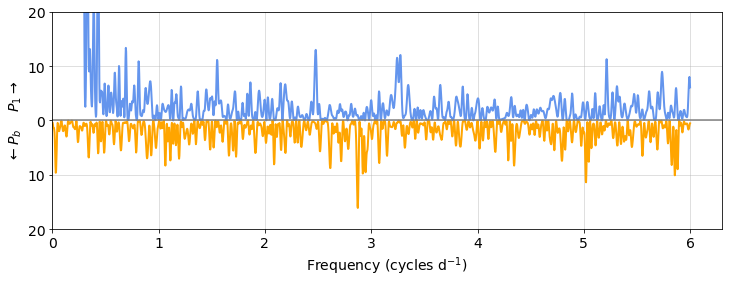 </figure>
<figure style="margin-left: 5%" title="Figure 3">   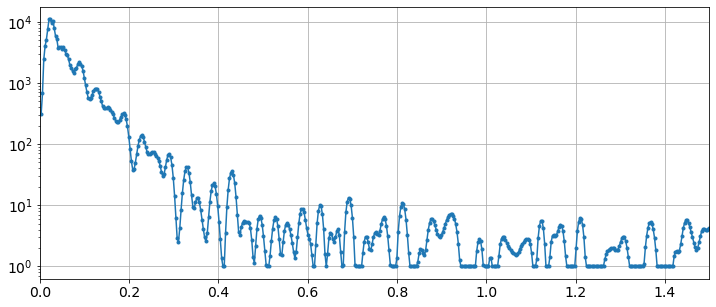 </figure>


In [64]:
flaresim(lambda t: 1e-6 + 100*lorenzian(t,30, 1), 'Lorenzian, width 1')

## Periodic
<figure style="margin-left: 5%" title="Figure 1">   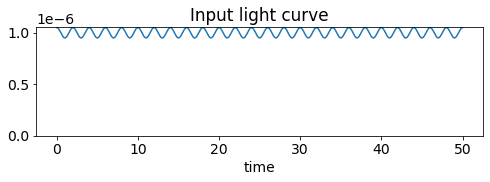 </figure>
<figure style="margin-left: 5%" title="Figure 2">   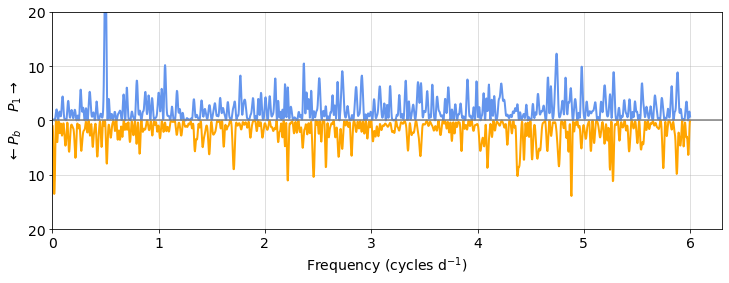 </figure>
<figure style="margin-left: 5%" title="Figure 3">   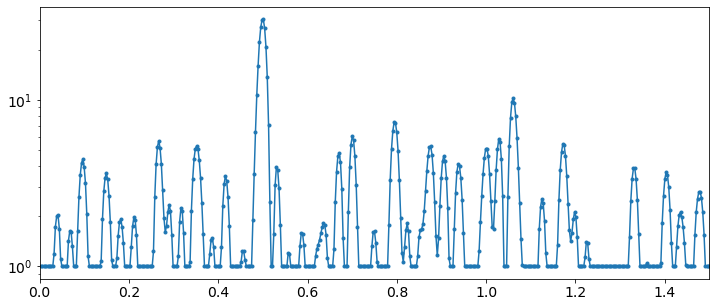 </figure>


In [53]:
flaresim(periodic, 'Periodic')

In [74]:
# hide
from nbdev.export2html import convert_nb
convert_nb('PKS_0208-512.ipynb', execute=False, dest='html')
